In [18]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os
from datetime import datetime, date

import seaborn as sns
import gensim

import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/Documents/Data/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from utils.text import *
from django.db.models import Q, Count, Func, F, Sum, Value, Case, When, IntegerField

### importing data

In [3]:
run_qs = RunStats.objects.filter(psearch__id=83, method="BD", status=3)

pd.DataFrame.from_dict(run_qs.values('run_id', 'coherence', 'exclusivity', 'K', 'alpha',
                                'top_chain_var', 'rng_seed', 'max_iter'))

,K,alpha,coherence,exclusivity,max_iter,rng_seed,run_id,top_chain_var
0,20,0.01,0.400404,0.523049,50,1,2154,0.010
1,45,0.05,0.514492,0.775650,50,1,2137,0.005
2,45,0.01,0.493715,0.846099,50,1,2145,0.010
3,45,0.05,0.370210,0.701541,50,1,2122,0.100
4,45,0.10,0.506084,0.780998,50,1,2121,0.005
5,45,0.10,0.491302,0.871996,50,1,2120,0.010
6,50,0.01,0.496631,0.781455,50,1,2112,0.005
7,45,0.10,0.416262,0.824821,50,1,2119,0.050
8,45,0.01,0.508955,0.742253,50,1,2111,0.005
9,45,0.05,0.480421,0.870453,50,1,2136,0.010


In [2]:
run_id = 2350
# for ISIE talk: run_id = 1749

save_dir = "./plots/topic_analysis_{}".format(run_id)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

dts = DocTopic.objects.filter(run_id=run_id)
# total score of all DocTopics
print(dts.aggregate(
    n = Sum('score')
))
# total score of DocTopics, sorted by topic
pd.DataFrame.from_dict(list(dts.values('topic__id', 'topic__title').annotate(
    totalscore = Sum('score')
).order_by('-totalscore')))

{'n': 3933832.45000197}


,topic__id,topic__title,totalscore
0,184089,stop words,419821.116446
1,184090,procedural,367744.157874
2,184081,economic policy,216063.202495
3,184105,federal government,158838.262969
4,184102,policy statements,156957.446933
5,184106,budget,148827.974002
6,184086,European Coal and Steel Community,144982.504003
7,184098,international cooperation,142685.511866
8,184108,energy policy,134634.299691
9,184097,procedural 2,124332.949316


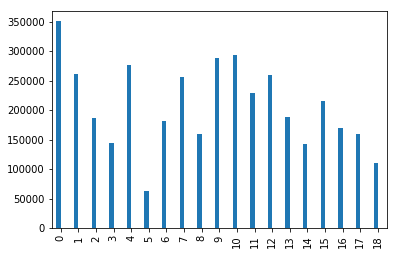

In [4]:
dts_list = list(dts.values('ut__document__parlperiod__n').annotate(
    n = Sum('score')
))
df_dts_list = pd.DataFrame(dts_list)
df_dts_list.columns = ['DocTopic_score', 'parlperiod']
df_dts_list.set_index('parlperiod')
df_dts_list.plot(kind='bar', legend=False)

In [5]:
stat = RunStats.objects.get(run_id=run_id)
search = stat.psearch
uts = pm.Utterance.objects.filter(search_matches=search)
print(uts.count())

period_counts = uts.values('document__parlperiod__n').annotate(n=Count('document__parlperiod__n'))
party_counts = uts.values('speaker__party__name').annotate(n=Count('speaker__party__name'))

9167


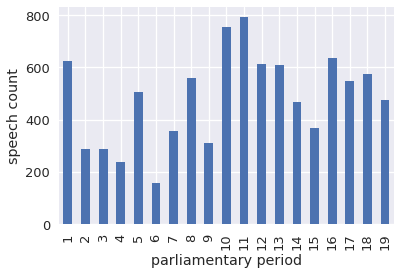

In [6]:
# plot parliamentary period counts
sns.set()
sns.set_context("talk")
df_period_counts = pd.DataFrame.from_dict(period_counts)
df_period_counts = df_period_counts.set_index('document__parlperiod__n')
df_period_counts.plot(kind='bar', legend=False)
plt.xlabel('parliamentary period')
plt.ylabel('speech count')
fig = plt.gcf()
fig.savefig(os.path.join(save_dir, 'parlperiod_speech_count_search_{}.png'.format(search.id)), dpi=300,  bbox_inches="tight")

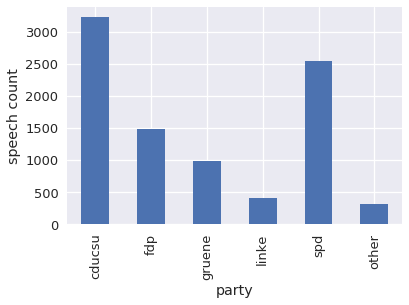

In [7]:
# plot party counts
df_party_counts = pd.DataFrame.from_dict(party_counts)
df_party_counts = df_party_counts.set_index('speaker__party__name')

# drop some of the labels:
#df_party_counts = df_party_counts.drop(["fraktionslos", "parteilos", "pds", None])
# or summarize them:
other_labels = ["bp", "dp", "drp", "dzp", "fraktionslos", "gb/bhe", "other", "parteilos", "pds", "wav", "afd", "kpd", None]
df_party_counts.loc["other"] = df_party_counts.loc[other_labels].sum()
df_party_counts = df_party_counts.loc[["cducsu", "fdp", "gruene", "linke", "spd", "other"]]

df_party_counts.plot(kind='bar', legend=False)
plt.xlabel('party')
plt.ylabel('speech count')
fig = plt.gcf()
fig.savefig(os.path.join(save_dir, 'party_speech_count_search_{}.png'.format(search.id)), dpi=300,  bbox_inches="tight")

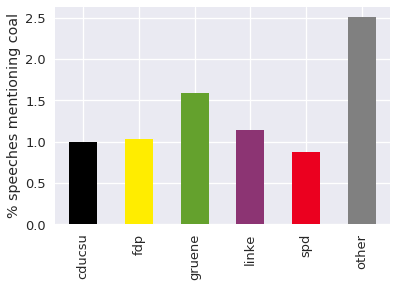

In [46]:
# party shares

party_counts = uts.values('speaker__party__name').annotate(n=Count('speaker__party__name'))

qs1 = pm.Utterance.objects.filter(document__date__lte=date(1996,2,7),
                            document__text_source__iregex="with agenda items - from https.*scans of pdfs with xml metadata",
                           ).values('speaker__party__name').annotate(Count('speaker__party__name'))

qs2 = pm.Utterance.objects.filter(document__text_source__iregex="with agenda items - GermaParlTEI"
                                 ).values('speaker__party__name').annotate(Count('speaker__party__name'))


qs3 = pm.Utterance.objects.filter(document__date__gte=date(2017,1,18),
                document__date__lte=date(2017,5,9),
                document__text_source__iregex="from https.*scans of pdfs with xml metadata"
                                 ).values('speaker__party__name').annotate(Count('speaker__party__name'))

qs4 = pm.Utterance.objects.filter(document__date__gte=date(2017,10,24),
                            document__text_source__iregex="updated - XML from www.bundestag.de/service/opendata"
                                 ).values('speaker__party__name').annotate(Count('speaker__party__name'))

party_counts_all = qs1.union(qs2, qs3, qs4)

df_party_counts_all = pd.DataFrame.from_dict(party_counts_all)
#df_party_counts_all = df_party_counts_all.set_index('speaker__party__name')
df_party_counts_all = df_party_counts_all.groupby('speaker__party__name').sum()

df_party_counts = pd.DataFrame.from_dict(party_counts)
df_party_counts = df_party_counts.set_index('speaker__party__name')

df_pc = df_party_counts.join(df_party_counts_all)

# drop some of the labels:
#df_pc = df_pc.drop(["fraktionslos", "parteilos", "pds", "afd", None])
# or summarize them:
df_pc.loc["other"] = df_pc.loc[["bp", "dp", "drp", "dzp", "fraktionslos", "gb/bhe", "other", "parteilos", "pds", "wav", "afd", "kpd", None]].sum()
df_pc = df_pc.loc[["cducsu", "fdp", "gruene", "linke", "spd", "other"]]

df_pc['share'] = 100 * df_pc['n'] / df_pc['speaker__party__name__count']

party_color_dict = {"afd": "#0088FF", "cducsu": "#000000", "fdp": "#FFED00", "gruene": "#64A12D",
                    "linke": "#8C3473", "spd": "#EB001F", "other": "grey"}

party_color = [party_color_dict[party] for party in df_pc.index]

df_pc.plot(kind='bar', y="share", legend=False, color=party_color)
plt.xlabel('')
plt.ylabel('% speeches mentioning coal')
fig = plt.gcf()
fig.savefig(os.path.join(save_dir,'party_share_search_{}.png'.format(search.id)), dpi=300,  bbox_inches="tight")

In [3]:
# plot parliamentary period by party

stat = RunStats.objects.get(run_id=run_id)
search = stat.psearch
uts = pm.Utterance.objects.filter(search_matches=search)
print(uts.count())

party_period_counts = uts.values('document__parlperiod__n', 'speaker__party__name').annotate(n=Count('document__parlperiod__n'))

9167


In [31]:
df_pp_counts = pd.DataFrame.from_dict(party_period_counts)
df_pp_counts = df_pp_counts.set_index(['speaker__party__name', 'document__parlperiod__n'])
df_pp_counts = df_pp_counts.unstack().fillna(0)
df_pp_counts

n                                                 \
document__parlperiod__n     1      2      3     4      5     6      7      8    
speaker__party__name                                                            
NaN                       15.0    5.0   17.0  13.0   20.0   1.0    6.0   15.0   
afd                        0.0    0.0    0.0   0.0    0.0   0.0    0.0    0.0   
bp                         8.0    0.0    0.0   0.0    0.0   0.0    0.0    0.0   
cducsu                   242.0  157.0  143.0  99.0  224.0  62.0  110.0  209.0   
dp                        21.0    0.0    0.0   0.0    0.0   0.0    0.0    0.0   
drp                        3.0    0.0    0.0   0.0    0.0   0.0    0.0    0.0   
dzp                       34.0    0.0    0.0   0.0    0.0   0.0    0.0    0.0   
fdp                       50.0   41.0   35.0  49.0   63.0  13.0   99.0  137.0   
fraktionslos               0.0    0.0    0.0   0.0    0.0   0.0    0.0    0.0   
gb/bhe                     0.0    9.0    0.0   0.0    0.0   0.0    0.0    0.0   
gruene                     0.0    0.0    0.0   0.0    0.0   0.0    0.0    0.0   
kpd                       89.0    0.0    0.0   0.0    0.0   0.0    0.0    0.0   
linke                      0.0    0.0    0.0   0.0    0.0   0.0    0.0    0.0   
other                      0.0    2.0    0.0   0.0    0.0   0.0    0.0    0.0   
parteilos                  1.0    0.0    0.0   0.0    0.0   0.0    0.0    0.0   
pds                        0.0    0.0    0.0   0.0    0.0   0.0    0.0    0.0   
spd                      138.0   72.0   93.0  75.0  194.0  81.0  140.0  198.0   
wav                       24.0    0.0    0.0   0.0    5.0   0.0    0.0    1.0   

                                                                          \
document__parlperiod__n     9      10     11     12     13     14     15   
speaker__party__name                                                       
NaN                       14.0   25.0   13.0   11.0   11.0   29.0    0.0   
afd                        0.0    0.0    0.0    0.0    0.0    0.0    0.0   
bp                         0.0    0.0    0.0    0.0    0.0    0.0    0.0   
cducsu                   113.0  274.0  333.0  232.0  219.0  146.0  123.0   
dp                         0.0    0.0    0.0    0.0    0.0    0.0    0.0   
drp                        0.0    0.0    0.0    0.0    0.0    0.0    0.0   
dzp                        0.0    0.0    0.0    0.0    0.0    0.0    0.0   
fdp                       65.0  138.0  117.0  141.0  146.0   79.0   74.0   
fraktionslos               0.0    0.0    0.0    0.0    0.0    0.0    0.0   
gb/bhe                     0.0    0.0    0.0    0.0    0.0    0.0    0.0   
gruene                     0.0   78.0   92.0   21.0   67.0   74.0   65.0   
kpd                        0.0    0.0    0.0    0.0    0.0    0.0    0.0   
linke                      3.0    0.0    0.0   39.0   13.0   12.0    5.0   
other                      0.0    0.0    0.0    0.0    0.0    0.0    0.0   
parteilos                  0.0    0.0    0.0    0.0    0.0    2.0    3.0   
pds                        0.0    0.0    0.0    1.0   24.0   10.0    0.0   
spd                      115.0  238.0  239.0  170.0  131.0  114.0   99.0   
wav                        0.0    1.0    0.0    0.0    0.0    0.0    0.0   

                                                     
document__parlperiod__n     16     17     18     19  
speaker__party__name                                 
NaN                        0.0    0.0    1.0   12.0  
afd                        0.0    0.0    0.0   71.0  
bp                         0.0    0.0    0.0    0.0  
cducsu                   149.0  148.0  122.0  118.0  
dp                         0.0    0.0    0.0    0.0  
drp                        0.0    0.0    0.0    0.0  
dzp                        0.0    0.0    0.0    0.0  
fdp                       93.0   98.0    0.0   43.0  
fraktionslos               0.0    1.0    0.0    0.0  
gb/bhe                     0.0    0.0    0.0    0.0  
gruene                   155

In [32]:
df_pp_counts.loc["other"] = df_pp_counts.loc[["afd", "bp", "dp", "drp", "dzp", "fraktionslos", "gb/bhe", "kpd", "other", "parteilos", "pds", "wav", float('nan')]].sum()
plot_df = df_pp_counts.loc[["cducsu", "fdp", "gruene", "linke", "spd", "other"]]
plot_df.sum()

   document__parlperiod__n
n  1                          625.0
   2                          286.0
   3                          288.0
   4                          236.0
   5                          506.0
   6                          157.0
   7                          355.0
   8                          560.0
   9                          310.0
   10                         754.0
   11                         794.0
   12                         615.0
   13                         611.0
   14                         466.0
   15                         369.0
   16                         636.0
   17                         548.0
   18                         574.0
   19                         477.0
dtype: float64

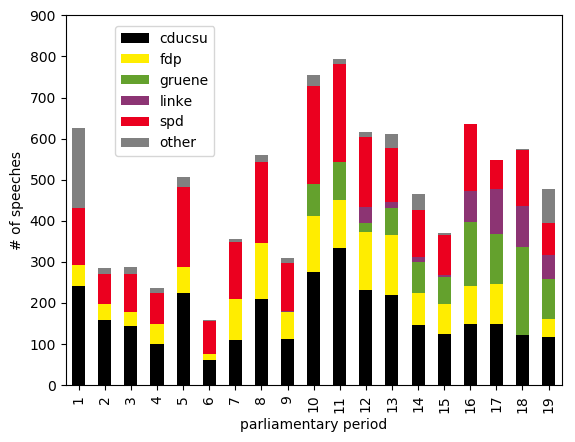

In [39]:
# reset style to matplotlib
sns.reset_orig()

party_color_dict = {"afd": "#0088FF", "cducsu": "#000000", "fdp": "#FFED00", "gruene": "#64A12D",
                    "linke": "#8C3473", "spd": "#EB001F", "other": "grey"}

party_color = [party_color_dict[party] for party in plot_df.index]

plot_df.transpose().plot(kind='bar', stacked=True, color=party_color)
plt.legend(loc=[0.1, 0.62])
plt.xlabel('parliamentary period')
plt.ylabel('# of speeches')
locs, labels = plt.xticks()            # Get locations and labels
plt.xticks(locs, range(1,20))  # Set locations and labels
plt.ylim([0,900])
fig = plt.gcf()
fig.savefig(os.path.join(save_dir,'speech_count_party_and_periods_search{}.png'.format(search.id)), dpi=300,  bbox_inches="tight")

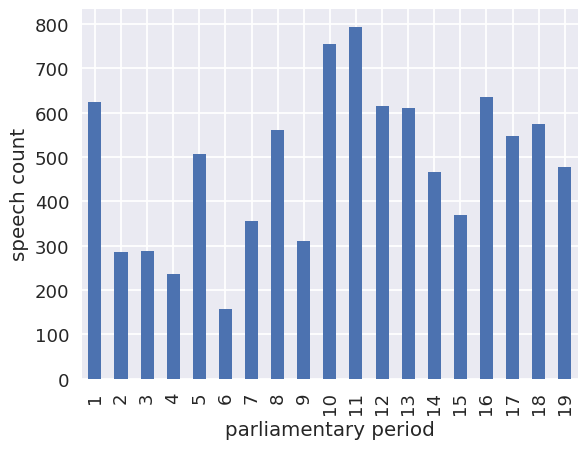

In [36]:

sns.set()
sns.set_context("talk")
df_period_counts = pd.DataFrame.from_dict(period_counts)
df_period_counts = df_period_counts.set_index('document__parlperiod__n')
df_period_counts.plot(kind='bar', legend=False)
plt.xlabel('parliamentary period')
plt.ylabel('speech count')
fig = plt.gcf()
fig.savefig(os.path.join(save_dir, 'parlperiod_speech_count_search_{}.png'.format(search.id)), dpi=300,  bbox_inches="tight")